GROUP PROJECT 4- EMPLOYEE PROMOTION PREDICTION.

In [15]:
import pandas as pd
import numpy as np
import time, re, string
import warnings
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import os
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [21]:
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100

Seting the directory

In [22]:
os.chdir(r'E:\JIGSAW\FinalProject')

In [23]:
os.getcwd()

'E:\\JIGSAW\\FinalProject'

Loading Train and Test Data Set.

In [24]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [25]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [26]:
train.nunique()

employee_id             54808
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
KPIs_met >80%               2
awards_won?                 2
avg_training_score         61
is_promoted                 2
dtype: int64

In [27]:
train.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [28]:
test.isnull().sum()

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

Dropping null values

In [29]:
train=train.dropna()

In [30]:
train.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

In [31]:
test=test.dropna()

In [32]:
test.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
dtype: int64

Defining categorical variables function, dropping employee_id column

In [33]:
def categorical_data(df,col):
    dff = df.copy()
    dff.drop('employee_id',axis=1,inplace=True)
    dff['dept&edu'] = dff['department'] + dff['education']
    dff['gender+edu'] = dff['gender'] + dff['education']
    dff = pd.DataFrame({col: dff[col].astype('category').cat.codes for col in dff}, index=dff.index)
    dff['awards_per_years'] = dff['awards_won?']/dff['length_of_service']
    dff['total_score'] = dff['avg_training_score']*dff['no_of_trainings']
    return dff

In [34]:
col = ['department','region','education','gender','recruitment_channel','dept&edu','gender+edu','dept&reg']
train_df = categorical_data(train,col)
test_df = categorical_data(test,col)
train_df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,dept&edu,gender+edu,awards_per_years,total_score
0,7,31,2,0,2,0,15,4,7,1,0,10,0,20,2,0.0,0
1,4,14,0,1,0,0,10,4,3,0,0,21,0,11,3,0.0,0
2,7,10,0,1,2,0,14,2,6,0,0,11,0,19,3,0.0,0
3,7,15,0,1,0,1,19,0,9,0,0,11,0,19,3,0.0,11
4,8,18,0,1,0,0,25,2,1,0,0,34,0,21,3,0.0,0


In [35]:
train_df.nunique()

department                9
region                   34
education                 3
gender                    2
recruitment_channel       3
no_of_trainings          10
age                      41
previous_year_rating      5
length_of_service        35
KPIs_met >80%             2
awards_won?               2
avg_training_score       61
is_promoted               2
dept&edu                 24
gender+edu                6
awards_per_years         21
total_score             139
dtype: int64

Splitting into test and train datasets

In [36]:
X_trn, X_val, Y_trn, Y_val = train_test_split(train_df.loc[:, train_df.columns != 'is_promoted'], train_df.is_promoted, test_size=0.1, shuffle=True, 
                                              random_state=42)

In [37]:
print ("Train_shape: " + str(X_trn.shape))
print ("Val_shape: " + str(X_val.shape))
print ("No of positives in train: " + str(Y_trn.sum()))
print ("No of positives in val: " + str(Y_val.sum()))

Train_shape: (43794, 16)
Val_shape: (4866, 16)
No of positives in train: 3823
No of positives in val: 409


Defining f1_score function

In [42]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

In [43]:
lgb_train = lgb.Dataset(X_trn, Y_trn)
lgb_eval = lgb.Dataset(X_val, Y_val)
evals_result = {} 

Defining boosting type,learning rate and bagging options

In [44]:
params = {
    'task': 'train',
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 11,
    'learning_rate': 0.01,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
}

Training the dataset using lgb which will calculate f1 score,auc

In [47]:
gbm = lgb.train(params, lgb_train, num_boost_round=5000, valid_sets=[lgb_eval, lgb_train], 
                valid_names=['val', 'train'], early_stopping_rounds=2000, feval=lgb_f1_score,
                evals_result=evals_result, verbose_eval=500)

Training until validation scores don't improve for 2000 rounds.
[500]	train's auc: 0.882283	train's f1: 0.296723	val's auc: 0.88237	val's f1: 0.290456
[1000]	train's auc: 0.898282	train's f1: 0.344961	val's auc: 0.895167	val's f1: 0.342742
[1500]	train's auc: 0.908014	train's f1: 0.42933	val's auc: 0.90504	val's f1: 0.428298
[2000]	train's auc: 0.913005	train's f1: 0.470915	val's auc: 0.907141	val's f1: 0.462687
[2500]	train's auc: 0.917881	train's f1: 0.488514	val's auc: 0.908766	val's f1: 0.478821
[3000]	train's auc: 0.92113	train's f1: 0.496094	val's auc: 0.910884	val's f1: 0.487179
[3500]	train's auc: 0.924089	train's f1: 0.499415	val's auc: 0.911555	val's f1: 0.495446
[4000]	train's auc: 0.926876	train's f1: 0.507949	val's auc: 0.911905	val's f1: 0.502712
[4500]	train's auc: 0.929049	train's f1: 0.510548	val's auc: 0.911948	val's f1: 0.505415
[5000]	train's auc: 0.931153	train's f1: 0.513623	val's auc: 0.911722	val's f1: 0.508108
Did not meet early stopping. Best iteration is:
[50

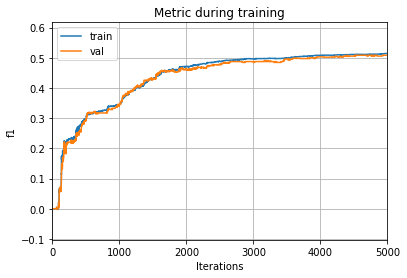

In [49]:
lgb.plot_metric(evals_result, metric='f1')

Feature-importance plotting

Plot feature importances


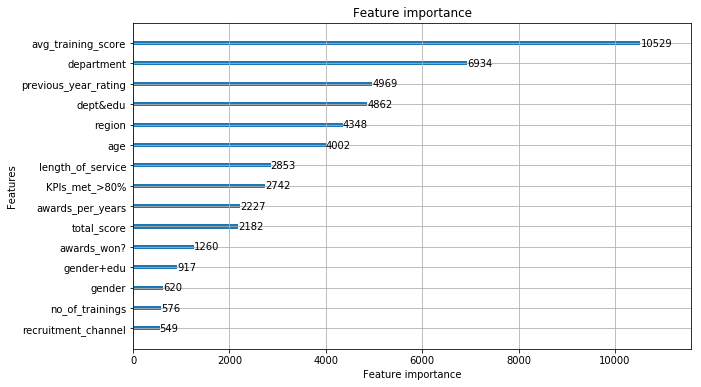

In [50]:
print('Plot feature importances')
ax = lgb.plot_importance(gbm, max_num_features=15, figsize=(10, 6))
plt.show()

In [51]:
y_trn_pred = gbm.predict(X_trn, num_iteration=gbm.best_iteration)
y_val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
y_train_pred = gbm.predict(train_df.loc[:, train_df.columns != 'is_promoted'], num_iteration=gbm.best_iteration)

In [52]:
y_pred = pd.DataFrame(y_train_pred)
y_pred.describe()

,0
count,48660.000000
mean,0.089684
std,0.160582
min,0.000278
25%,0.003967
50%,0.019771
75%,0.130232
max,0.999448


In [53]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([f1_score(Y_val, np.int32(y_val_pred > threshold)) for threshold in thresholds])

In [54]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

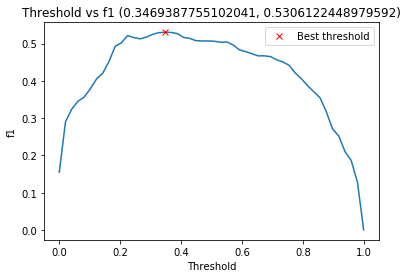

In [55]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("f1")
plt.title("Threshold vs f1 ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [56]:
TH = threshold_best

for i in range(0, len(y_trn_pred)):
    if y_trn_pred[i] < TH:
        y_trn_pred[i] = 0
    else:
        y_trn_pred[i] = 1

for i in range(0, len(y_val_pred)):
    if y_val_pred[i] < TH:
        y_val_pred[i] = 0
    else:
        y_val_pred[i] = 1

for i in range(0, len(y_train_pred)):
    if y_train_pred[i] < TH:
        y_train_pred[i] = 0
    else:
        y_train_pred[i] = 1

Printing the model scores - Precision, Recall and F1 Score

Precision - Positive predictive value is used for binary classification of data i.e our dependent variable is is_promoted, it is  is the fraction of relevant instances among the retrieved instances.

Recall or sensitivity - is the fraction of relevant instances that have been retrieved over the total amount of relevant instances.

Both are based on understanding of measure and relevance.

F1 Score - It is the harmonic mean of Precision and Recall.

In [57]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
print ('Training Set')
print ('Precision: ', precision_score(Y_trn, y_trn_pred))
print ('Recall: ', recall_score(Y_trn, y_trn_pred))
print ('F1 Score: ', f1_score(Y_trn, y_trn_pred))

print ('Validation Set')
print ('Precision: ', precision_score(Y_val, y_val_pred))
print ('Recall: ', recall_score(Y_val, y_val_pred))
print ('F1 Score: ', f1_score(Y_val, y_val_pred))

Training Set
Precision:  0.9150769230769231
Recall:  0.3889615485221031
F1 Score:  0.5458883994126285
Validation Set
Precision:  0.8715083798882681
Recall:  0.38141809290953543
F1 Score:  0.5306122448979592


In [ ]:
Interpreting results :
    
Precision is high, it means that our model was able to predict high relevant results than the irrelevant ones.
Recall score implies that algorithm returned maximum of relevant results.

F1 score is the harmonic mean of precision and Recall scores and is acting as an evaluation metric, in our case value is more than 0.5 which suggests that our model quality and quantity is 
fairly predicted. highest  F1 score is 1, so more than 0.5 is fairly accurate.


Predicting - we have taken the best iteration from the gbm prediction.

In [58]:
y_pred_test = gbm.predict(test_df, num_iteration=gbm.best_iteration)
for i in range(0, len(y_pred_test)):
    if y_pred_test[i] < TH:
        y_pred_test[i] = 0
    else:
        y_pred_test[i] = 1

Final Prediction into a blank CSV as Sub dataframe whether the employee is promoted or not.

In [59]:
sub = pd.DataFrame()
sub.shape

(0, 0)

In [60]:
sub['is_promoted'] = y_pred_test
sub['is_promoted'].astype('int', inplace=True)
sub.head

<bound method NDFrame.head of        is_promoted
0              0.0
1              0.0
2              0.0
3              0.0
4              0.0
5              0.0
6              0.0
7              0.0
8              0.0
9              0.0
10             0.0
11             0.0
12             0.0
13             0.0
14             0.0
15             0.0
16             0.0
17             0.0
18             0.0
19             0.0
20             0.0
21             0.0
22             0.0
23             0.0
24             0.0
25             0.0
26             0.0
27             0.0
28             0.0
29             0.0
...            ...
20789          0.0
20790          0.0
20791          0.0
20792          0.0
20793          0.0
20794          0.0
20795          0.0
20796          0.0
20797          0.0
20798          0.0
20799          0.0
20800          0.0
20801          0.0
20802          0.0
20803          0.0
20804          0.0
20805          0.0
20806          0.0
20807          0.0
2

Dumping the result into a CSV, which contains is_promoted column.

In [61]:
sub.to_csv('Predicted_Promotion_lgbm.csv', index=False)

In [62]:
Promoted = pd.read_csv('Predicted_Promotion_lgbm.csv')

In [63]:
Promoted.head(10)

,is_promoted
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [64]:
Promoted.describe()

,is_promoted
count,20819.000000
mean,0.035112
std,0.184068
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Finally, we have predicted which employee will be promoted.
730 employees got promoted out of 20,819.